### Import all required libraries

In [137]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from keras.callbacks import ModelCheckpoint
%matplotlib inline

### Load the image data or define the data loader

In [138]:
cols = ['Label', 'Latin Name', 'Common Name', 'Train Image', 'Validation Images']
monkeys = pd.read_csv(f"monkey_labels.txt", names=cols, skiprows=1)
height = 224
width = 224
#make the data generator.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(
    'training/training/',
    target_size=(height, width),
    batch_size=1,
    shuffle=False)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = train_datagen.flow_from_directory(
    'validation/validation/',
    target_size=(height, width),
    batch_size=1,
    shuffle=False)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [139]:
monkeys

,Label,Latin Name,Common Name,Train Image,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


### Load a pre-trained model

In [140]:
mobileNet = tf.keras.applications.MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
mobileNet.trainable = False

### Transform the image data to the features of the last convolutional layer

In [142]:
features = np.zeros([1098, 7, 7, 1024])
labels = np.zeros(1098)
labels_oh = np.zeros([1098, 10])
for i in range(1098):
    feature = mobileNet.predict(train_generator[i][0])
    features[i] = feature
    labels_oh[i] = train_generator[i][1].reshape(-1)
    labels[i] = train_generator[i][1].reshape(-1).argmax()
    if i % 100 == 0:
        print("finished {} procent!".format(i // 10))

finished 0 procent!
finished 10 procent!
finished 20 procent!
finished 30 procent!
finished 40 procent!
finished 50 procent!
finished 60 procent!
finished 70 procent!
finished 80 procent!
finished 90 procent!
finished 100 procent!


### Apply PCA to the transformed CNN features

In [143]:
features = features.reshape([1098, 7*7*1024])
pca_model = PCA(n_components=2)
features_d = pca_model.fit_transform(features)

### Plot the two dimensional data distribution

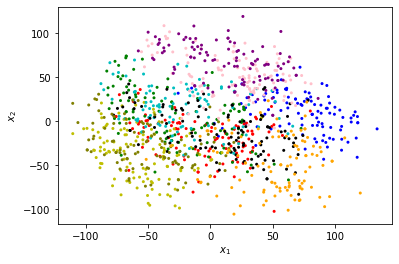

In [145]:
cmap = ListedColormap(['b', 'r', 'g', 'y', 'c', 'm', 'k', 'olive', 'pink', 'purple', 'orange'])
plt.figure()
plt.scatter(features_d[:, 0], features_d[:, 1], c=labels, marker='.', cmap=cmap, edgecolors='none', label="train data")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.savefig("two_dim_data")
plt.show()

### Evaluate a kNN with k=1 on the two dimensional data distribution

In [146]:
cls = KNeighborsClassifier(n_neighbors=1)
cls.fit(features_d, labels)
features_test = np.zeros([272, 7, 7, 1024])
y_label = np.zeros([272])
label_test_oh = np.zeros([272, 10])
for i in range(272):
    features_test[i] = mobileNet(test_generator[i][0])
    y_label[i] = test_generator[i][1].reshape(-1).argmax()
    label_test_oh[i] = test_generator[i][1].reshape(-1)
features_test_d = pca_model.transform(features_test.reshape([272, 7*7*1024]))
y_pred = cls.predict(features_test_d)

In [147]:
acc = (y_pred == y_label).sum() / 272
print("The accuracy of validation sets is: {}".format(acc))

The accuracy of validation sets is: 0.4117647058823529


### Add a custom classification head on the pre-trained model

In [148]:
fc_model = tf.keras.Sequential([
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
fc_model.build(input_shape=[None, 7*7*1024])
fc_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 5000)              250885000 
_________________________________________________________________
dense_10 (Dense)             (None, 100)               500100    
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1010      
Total params: 251,386,110
Trainable params: 251,386,110
Non-trainable params: 0
_________________________________________________________________


### Define your training setup

In [149]:
epochs = 50
batch_size = 64
checkpoint = ModelCheckpoint("monkey_model.h5f", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
ls=tf.keras.losses.CategoricalCrossentropy()
features_test = features_test.reshape([272, 7*7*1024])
fc_model.compile(
    optimizer = 'sgd', 
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False),
    metrics = ['acc'])

### Run the training process

In [150]:
history = fc_model.fit(
    features, labels_oh,
    batch_size = batch_size,
    validation_data = (features_test, label_test_oh),
    steps_per_epoch = 5,
    epochs = epochs,
    callbacks=[checkpoint],
    verbose=1)

Epoch 1/50
5/5 [==============================] - 11s 2s/step - loss: 7.6928 - acc: 0.1469 - val_loss: 3.9712 - val_acc: 0.1029

Epoch 00001: val_acc improved from -inf to 0.10294, saving model to monkey_model.h5f
INFO:tensorflow:Assets written to: monkey_model.h5f\assets
Epoch 2/50
5/5 [==============================] - 9s 2s/step - loss: 5.2799 - acc: 0.1125 - val_loss: 2.4827 - val_acc: 0.1654

Epoch 00002: val_acc improved from 0.10294 to 0.16544, saving model to monkey_model.h5f
INFO:tensorflow:Assets written to: monkey_model.h5f\assets
Epoch 3/50
5/5 [==============================] - 8s 2s/step - loss: 2.3203 - acc: 0.1219 - val_loss: 2.2438 - val_acc: 0.1213

Epoch 00003: val_acc did not improve from 0.16544
Epoch 4/50
5/5 [==============================] - 11s 2s/step - loss: 2.3264 - acc: 0.1278 - val_loss: 2.2121 - val_acc: 0.1434

Epoch 00004: val_acc did not improve from 0.16544
Epoch 5/50
5/5 [==============================] - 12s 3s/step - loss: 2.3908 - acc: 0.1719 - va

### Plot the learning curves

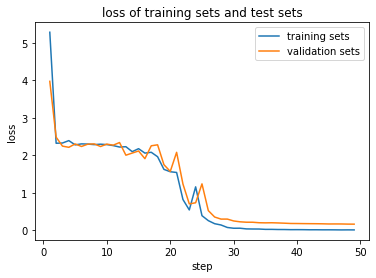

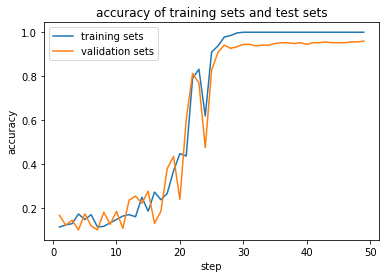

In [152]:
plt.figure()
steps = np.arange(1, epochs)
plt.plot(steps, history.history["loss"][1:], label="training sets")
plt.plot(steps, history.history["val_loss"][:-1], label="validation sets")
plt.xlabel("step")
plt.ylabel("loss")
plt.title("loss of training sets and test sets")
plt.legend()
plt.savefig("loss_pic.png")
plt.show()
plt.figure()
plt.plot(steps, history.history["acc"][1:], label="training sets")
plt.plot(steps, history.history["val_acc"][1:], label="validation sets")
plt.xlabel("step")
plt.ylabel("accuracy")
plt.title("accuracy of training sets and test sets")
plt.legend()
plt.savefig("acc_pic.png")
plt.show()

Here we use this model to predict two monkeys. From the training step, we can see that the accuracy of the most accurate model is 0.9596. This model is good to estimate the class of monkey.

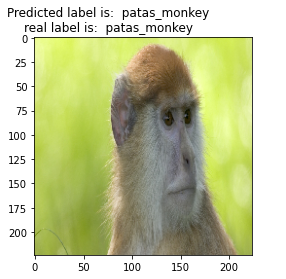

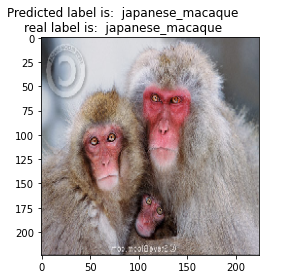

In [153]:
def predict_monkey(mobileNet, fc_model, testdata):
    fc_model.trainable = False
    real_name = monkeys["Common Name"][int(tf.argmax(testdata[1][0]))]
    features = tf.reshape(mobileNet.predict(testdata[0]), [-1, 50176])
    result = int(tf.argmax(tf.reshape(fc_model.predict(features), [10])))
    pred_name = monkeys["Common Name"][result]
    plt.figure()
    plt.imshow(testdata[0][0])
    plt.title("Predicted label is: " + real_name + "\nreal label is: " + pred_name)
predict_monkey(mobileNet, fc_model, test_generator[50])
predict_monkey(mobileNet, fc_model, test_generator[100])